In [1]:
using LinearAlgebra, Random, Plots, Printf, Latexify, LaTeXStrings

The relative error of a scalar is indicative of the number of correct digits of its approximation. For example, consider $\pi=3.1415926\dots$, we have

| $\hat{\pi}$ | $|\hat{\pi}-\pi|/|\pi|$|
|-------------|------------------------|
|  $3.1$      | $1.323935\times10^{-2}$|
|  $3.141$    | $1.886475\times10^{-4}$|
|  $3.141592$ | $2.080440\times10^{-7}$|
|  $3.1415926$| $1.705816\times10^{-8}$|


When we subtract two nearly equal numbers, their most significant digits cancel out, leading to a floating-point number that less accurately approximates the difference. This is **cancellation error**.

For example, consider the number $\pi$ stored in 32 bits, i.e., π32, and its representation error:

In [2]:
π32 = Float32(pi)
rel_error_π32 = abs(Float64(π32) - pi) / abs(pi)
@printf "π = %.8f, π32 = %.8f, rel. error = %.2E" π π32 rel_error_π32

π = 3.14159265, π32 = 3.14159274, rel. error = 2.78E-08

We see that π32 has around 8 significant digits.

Then, we want to evaluate the difference between $\,\pi\,$ and a nearly equal number, say $\;\Delta=\pi-3.14$. We also are interested in the approximation Δ32 of this number, done by evaluating π32 - 3.14 in 32 bits, and we look at the relative error between Δ and Δ32:

In [3]:
Δ32 = Float32(3.14) - π32
Δ = 3.14 - pi
rel_error_Δ = abs(Float64(Δ32) - Δ) / abs(Δ)
@printf "Δ = %.5E, Δ32 %.5E, rel_error_Δ = %.2E" Δ Δ32 rel_error_Δ

Δ = -1.59265E-03, Δ32 -1.59264E-03, rel_error_Δ = 1.10E-05

We see the number of significant digits of Δ32 dropped to 5, from previously 8 digits for π32.

However, the representation of Δ with 32 bits still has around 8 significant digits:

In [4]:
rel_error_Δ32 = abs(Float64(Float32(Δ)) - Δ) / abs(Δ)
@printf "Δ = %.5E, Float32(Δ) %.5E, rel_error_Δ32 = %.2E" Δ Float64(Float32(Δ)) rel_error_Δ32

Δ = -1.59265E-03, Float32(Δ) -1.59265E-03, rel_error_Δ32 = 1.20E-08

So, the increase of relative error obtained when evaluating $\,\Delta 32\,$ using floating-point arithmetic with 32 bits is indeed due to cancellation. 

Let us consider the integral $\;I_n=\int_0^1x^ne^{-x}dx$, which we wish to evalue as a function of $\;n$.

Upon integrating by parts we get the recursive formula $\;I_n=n\cdot I_{n-1}-1/e\;$ with a base case $\;I_0=1-1/e$.

The recursive formula is implemented as follows:

In [2]:
function I(n)
  if n == 0
    return 1. - exp(-1)
  end
  return n * I(n-1) - exp(-1)
end;

Now, we wish to test ```I(n)```. We know that $\;I_{100}\approx 3.678430281\times 10^{-3}$. What does ```I(100)``` give us?

In [3]:
I0   = 6.321205588e-1;
I10  = 3.646133462e-2;
I50  = 7.354706796e-3;
I100 = 3.678430281e-3;
I300 = 1.226251224e-3;

II100 = I(100)
println("I_100 = ", II100)
println("rel. error: ", abs(I100 - II100) / abs(I100))

I_100 = -3.1530126806564304e141
rel. error: 8.571625502711085e143


The value returned by ```I(100)``` is completely off from the expected result, showing a breakdown of the numerical method. Why is that?

To answer this question, let us first look at what comes into the recursive computation of $\;I_{n+1}\;$ for different values of $\;n$, namely $\;n\cdot I_{n-1}\;$ and $\;1/e$:

In [4]:
println("1 * I0 = ", I0, ", exp(-1) = ", exp(-1));
println("11 * I10 = ", 10 * I10, ", exp(-1) = ", exp(-1));
println("51 * I50 = ", 51 * I50, ", exp(-1) = ", exp(-1));
println("101 * I100 = ", 101 * I100, ", exp(-1) = ", exp(-1));

1 * I0 = 0.6321205588, exp(-1) = 0.36787944117144233
11 * I10 = 0.3646133462, exp(-1) = 0.36787944117144233
51 * I50 = 0.37509004659600004, exp(-1) = 0.36787944117144233
101 * I100 = 0.371521458381, exp(-1) = 0.36787944117144233


We see that the true value of $\;n\cdot I_{n-1}\;$ grows closer to $\;1/e\;$ as $\;n\;$ increases. Then, ```I(n)``` attempts to evaluate $\;I_{n}\;$ by subtracting these increasingly close numbers, which leads to __cancellation error__. In addition to this, $I_n$ is then multiplied by $n+1$ in order to compute $I_{n+1}$. As $n$ grows, this means the cancellation error may be maginified, accelerating the propagation of errors. 

In order to circumvent this issue, we should try and reformulate the recursion so as to not have differences of nearly equal numbers multiplied by large numbers.

For that, note that the recursion can be recast into $\;I_{n-1}=1/n\cdot(I_n+1/e)$, which is used backwards, from a base case $\;I_m\;$ with $\;m>n$. Let us for instance use $\;I_{300}\;$ as a base case. The backward recursion is implemented as follows:

In [5]:
function J(n)
  J = 1.226251224e-3
  i = 300
  while (i > n)
    J = (1. / i) * (J + exp(-1))
    i -= 1
  end
  return J
end;

Let us now test ```J(n)``` to compute $\;I_{100}$.

In [6]:
J100 = J(100)
println("J_100 = ", J100)
println("rel. error: ", abs(I100 - J100) / abs(I100))

J_100 = 0.0036784302813674887
rel. error: 9.990364464392733e-11


The problem now is fixed.

This problem was suggested by Luc Giraud from Inria, Bordeaux.

Let us consider the linear system $Ax=b$ given by

$$
A=\begin{bmatrix}1&1\\1+\varepsilon&1\end{bmatrix}
\;\text{ and }\;
b=\begin{bmatrix}b_1\\b_1+\varepsilon\end{bmatrix}
\;\text{ with }\;
\varepsilon>0.
$$

The unique exact solution of this system is given by 
$$
x=\begin{bmatrix}1\\b_1-1\end{bmatrix}.
$$

The matrix $A$ has eigenvalues $\lambda_{min}=1-\sqrt{1+\varepsilon}$ and $\lambda_{max}=1+\sqrt{1+\varepsilon}$, so that $\|A\|_2=\lambda_{max}=1+\sqrt{1+\varepsilon}$ and, the condition number for solving a linear system with $A$ is
$$
\kappa(A)=\|A^{-1}\|_2\|A\|_2=\frac{|\lambda_{max}(A)|}{|\lambda_{min}(A)|}=\frac{1+\sqrt{1+\varepsilon}}{|1-\sqrt{1+\varepsilon}|}=\frac{(1+\sqrt{1+\varepsilon})^2}{\varepsilon}
\hspace{1cm}\text{($A$ is normal)}.
$$
That is, solving for $\;x\;$ is an ill-conditioned problem for sufficiently small values of $\;\varepsilon$. For example, we have

In [7]:
function get_A(ε)
  return [1.   1.;
          1+ε  1.]
end;

get_b(b1, ε) = [b1;b1+ε];
get_κ(ε) = (1 + sqrt(1+ε))^2/ε;
get_x(b, ε) = [1.; b[1]-1.];

for ε ∈ (1e-3, 1e-4, 1e-5, 1e-6)
  κ = get_κ(ε);
  @printf "ε = %.0E, κ = %.1E\n" ε κ
end

ε = 1E-03, κ = 4.0E+03
ε = 1E-04, κ = 4.0E+04
ε = 1E-05, κ = 4.0E+05
ε = 1E-06, κ = 4.0E+06


Now, in practice some of the components of $A$ and $b$ may not be exactly stored. In particular, we may rather have

$$
B=\begin{bmatrix}1&1\\\mathrm{fl}(1+\varepsilon)&1\end{bmatrix}
\;\text{ and }\;
c=\begin{bmatrix}\mathrm{fl}(b_1)\\\mathrm{fl}(b_1+\varepsilon)\end{bmatrix}
\;\text{ with }\;
\varepsilon>0.
$$

If that is so, assuming $\;\mathrm{fl}(1+\varepsilon)>1\;$ so that $\;B\;$ remains invertible, the true solution $\;y\;$ of $\;By=c\;$ is

$$
y=
\frac{1}{\mathrm{fl}(1+\varepsilon)-1}
\begin{bmatrix}
\mathrm{fl}(b_1+\varepsilon)-\mathrm{fl}(b_1)\\
\mathrm{fl}(1+\varepsilon)\cdot\mathrm{fl}(b_1)-\mathrm{fl}(b_1+\varepsilon)
\end{bmatrix}.
$$

In case of non-zero representation errors, $\;y\;$ is only an approximation of $\;x$, i.e., the true solution of the non-perturbed system $\;Ax=b$. 
We saw in class that the minimally normed perturbations $\;\delta A\;$ and $\;\delta b\;$ such that $\;(A+\delta A)y=b+\delta b$ are given by
$$
\delta A=\frac{\|A\|_2}{\|y\|_2\cdot(\|A\|_2\cdot\|y\|_2+\|b\|_2)}\;ry^T
\;\text{ and }\;
\delta b=-\frac{\|b\|_2}{\|A\|_2\cdot\|y\|_2+\|b\|_2}\; r
$$
where $r=b-Ay$, and so that
$$
\eta_{A,b}(y)=\frac{\|r\|_2}{\|A\|_2\cdot\|y\|_2+\|b\|_2}=\frac{\|\delta A\|_2}{\|A\|_2}=\frac{\|\delta b\|_2}{\|b\|_2}.
$$
In this particular case, since $\;B-A\;$ and $\;c-a\;$ are very small, we actually have 
$$
\eta_{A,b}(y)\approx\frac{\|B-A\|_2}{\|A\|_2}=\frac{\|c-b\|_2}{\|b\|_2}.
$$

Now, what we wish to show is that, **even though the backward error** $\,\eta_{A,b}(y)\,$ **may be small, the relative forward error** $\,\|x-y\|_2/\|x\|_2\,$ **may actually be large, because of the ill-conditioned nature of the problem reflected by the values of** $\kappa(A)$.

In [8]:
function get_y(b, ε)
    arithmetic = :fl64 # fl32
    if (arithmetic == :fl32)
      a21_32 = Float32(1+ε)
      b1_32  = Float32(b[1])
      b2_32  = Float32(b[1]+ε)
      return [Float64((b2_32-b1_32)/(a21_32-1));
              Float64((a21_32*b1_32-b2_32)/(a21_32-1))]
    else
      a21_64 = Float64(Float32(1+ε))
      b1_64  = Float64(Float32(b[1]))
      b2_64  = Float64(Float32(b[1]+ε))
      return [(b2_64-b1_64)/(a21_64-1);
              (a21_64*b1_64-b2_64)/(a21_64-1)]
    end
end

function get_η(y, ε, b, r)
  A_2norm = 1+sqrt(1+ε)
  b_2norm = sqrt(b'b)
  r_2norm = sqrt(r'r)
  y_2norm = sqrt(y'y)
  d = A_2norm * y_2norm + b_2norm
  return r_2norm / d
end;

function get_δA(y, ε, b, r)
  A_2norm = 1+sqrt(1+ε)
  b_2norm = sqrt(b'b)
  y_2norm = sqrt(y'y)
  c = A_2norm / y_2norm / (A_2norm * y_2norm + b_2norm)
  return c * r * y'
end;

function get_δb(y, ε, b, r)
  A_2norm = 1+sqrt(1+ε)
  b_2norm = sqrt(b'b)
  y_2norm = sqrt(y'y)
  c = - b_2norm / (A_2norm * y_2norm + b_2norm)
  return c * r
end;

function check(y, ε, A, b, r)
  δA = get_δA(y, ε, b, r)
  δb = get_δb(y, ε, b, r)
  z = (A + δA) \ (b + δb)
  println(norm(y - z))
end

b1 = 22.

for ε ∈ (1e-3, 1e-4, 1e-5, 1e-6)
  A = get_A(ε);
  b = get_b(b1, ε);
  κ = get_κ(ε);
  x = get_x(b, ε);
  y = get_y(b, ε);
  r = b - A * y;
  forward_error = sqrt((x-y)'*(x-y))/sqrt(x'x);
  backward_error = get_η(y, ε, b, r);
  # check(y, ε, A, b, r);
  @printf "ε = %.0E, κ = %.1E, backward_error = %.4E, forward_error = %.4E\n" ε κ backward_error forward_error
end

ε = 1E-03, κ = 4.0E+03, backward_error = 8.1454E-09, forward_error = 4.0093E-05
ε = 1E-04, κ = 4.0E+04, backward_error = 1.1401E-08, forward_error = 5.6123E-04
ε = 1E-05, κ = 4.0E+05, backward_error = 6.5008E-09, forward_error = 3.2032E-03
ε = 1E-06, κ = 4.0E+06, backward_error = 1.4023E-08, forward_error = 6.7267E-02


We can see that, as the condition number $\,\kappa(A)\,$ of the problem increases, the backward error $\,\eta_{A,b}(y)$, which characterizes the approximation $\,y\,$ of $\,x\,$, becomes less and less indicative of the relative forward error. Indeed, we do have
$$
\frac{\|x-y\|_2}{\|x\|_2}\;\lesssim\;\kappa(A)\;\times\;\eta_{A,b}(y).
$$

We saw during the lecture that the condition number was a problem-dependent quantity. In order to showcase this, we take a look at a specific type of matrix which is well-conditioned for linear solves, but has ill-conditioned eigenvalues.

We consider the Grcar matrix (see https://math.nist.gov/MatrixMarket/data/NEP/mvmgrc/mvmgrc.html) which is upper Hessenberg, and thus, non-normal.

In [9]:
function get_A(n)
  A = zeros(n, n);
  A[diagind(A, -1)] .= -1.;
  for i in 0:3
    A[diagind(A, i)] .= 1.;
  end
  return A
end

println("For n=10, the Grcar matrix looks like this:")
latex_string = L"A = " * latexify(get_A(10));
display("text/latex", latex_string);

For n=10, the Grcar matrix looks like this:


This matrix has a small condition number κ(A) with respect to linear solves. In particular, for n=100, we have:

In [10]:
n = 100;
A = get_A(n);
κ = cond(A)

3.5911104629805917

The small value of $\kappa=\|A^{-1}\|_2\|A\|_2$ means that the solution $\,x\,$ of the linear system $\,Ax=b\,$ is not highly sensitive to perturbations. That is, the true solution $\,y\,$ of $\,(A+\delta A)y=b+\delta b\,$ remains close to $\,x\,$, as long as $\,\|\delta A\|_2\,$ and $\,\|\delta b\|_2\,$ are small. We can put this to the test as follows:

In [11]:
Random.seed!(123467);
b = 1 .+ rand(n);
A_2norm = norm(A);
b_2norm = norm(b);

x = A \ b

δA0 = rand(n, n); δA0 ./= norm(δA0);
δb0 = rand(n); δb0 ./= norm(δb0);

for ε ∈ (1e-5, 1e-4, 1e-3, 1e-2)
  δA = ε * δA0
  δb = ε * δb0
  y = (A + δA) \ (b + δb)
  rel_error = norm(y - x) / norm(x)
  @printf "||δA||_2/||A||_2 = %.2E, ||δb||_2/||b||_2 = %2.E, ||y - x||_2/||x||_2 = %.2E\n" norm(δA)/A_2norm norm(δb)/b_2norm rel_error
end

||δA||_2/||A||_2 = 4.50E-07, ||δb||_2/||b||_2 = 6E-07, ||y - x||_2/||x||_2 = 2.28E-06
||δA||_2/||A||_2 = 4.50E-06, ||δb||_2/||b||_2 = 6E-06, ||y - x||_2/||x||_2 = 2.28E-05
||δA||_2/||A||_2 = 4.50E-05, ||δb||_2/||b||_2 = 6E-05, ||y - x||_2/||x||_2 = 2.28E-04
||δA||_2/||A||_2 = 4.50E-04, ||δb||_2/||b||_2 = 6E-04, ||y - x||_2/||x||_2 = 2.28E-03


where we see that the forward error $\,\|y-x\|_2/\|x\|_2\,$ is properly measured by the relative perturbations $\,\|\delta A\|_2/\|A\|_2\,$ and $\,\|\delta b\|_2/\|b\|_2\,$ multiplied by the moderatly small condition number $\,\kappa(A)$.

Now, let us look into the eigenvalues of $\,A$.

We remember the condition number $\,\kappa(A,\lambda)\,$ of an eigenvalue $\,\lambda\,$ with normalized right- and left-eigenvectors $\,u\,$ and $\,v\,$, respectively, i.e., such that
$$
Au=\lambda u,
\;\;
A^Hv=\overline{\lambda}v,
\;\;
\|u\|_2=\|v\|_2=1
$$
is given by
$$
\kappa(A,\lambda)=\frac{1}{|v^Hu|}
$$
so that $\,\kappa(A,\lambda)\,$ becomes increasingly large as the right- and left-eigenvectors $\,u\,$ and $\,v\,$ are close to be orthogonal.

For the case of the Grcar matrix, we can see that the condition number is very high, for all the eigenvalues. For example, we have

In [12]:
Λ, U = eigen(A);
Θ, V = eigen(transpose(A));
κ_λ1 = 1. / norm(U[:,1]'V[:,2]);
κ_λn = 1. / norm(U[:,n]'V[:,n-1]);
@printf "κ_λ1 = %.2E, κ_λn = %.2E" κ_λ1 κ_λn

κ_λ1 = 1.85E+14, κ_λn = 1.09E+06

Let us now showcase the ill-conditioning of these eigenvalues by applying small perturbation $\,\delta A\,$ to $\,A$, and see what the effect is on the spectrum:

In [13]:
δA = 1e-5 * δA0
Θ = eigvals(A + δA)
rel_error_1 = norm(Λ[1] - Θ[1]) / norm(Λ[1])
rel_error_n = norm(Λ[n] - Θ[n]) / norm(Λ[n])
@printf "||δA||_2/||A||_2 = %.2E, |λ1 - θ1|/|λ1| = %.2E, |λn - θn|/|λn| = %.2E\n" norm(δA)/A_2norm  rel_error_1 rel_error_n

||δA||_2/||A||_2 = 4.50E-07, |λ1 - θ1|/|λ1| = 1.25E-01, |λn - θn|/|λn| = 5.94E-01


We can see that despite the fact that the perturbation is small, the effect on the eigenvalues with smallest and largest magnitudes is very strong.

It is worth observing the effect of the entire spectrum:

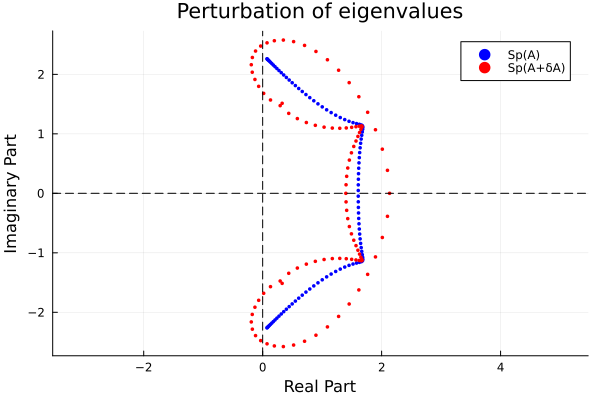

In [14]:
p = scatter(real.(Λ), imag.(Λ), xlabel="Real Part", ylabel="Imaginary Part", title="Perturbation of eigenvalues", 
            label="Sp(A)", marker=:circle, markersize=2, markerstrokewidth=0, color=:blue, aspect_ratio=:equal)
scatter!(p, real.(Θ), imag.(Θ), label="Sp(A+δA)", marker=:circle, markersize=2, markerstrokewidth=0, color=:red)
hline!([0], color=:black, linestyle=:dash, label="")
vline!([0], color=:black, linestyle=:dash, label="")
display(current())

Hence, we see that, despite being well-conditioned for linear solves, the Grcar matrix has ill-conditioned eigenvalues, which confirms that, indeed, **the condition number is a problem-dependent quantity**.